# Homework 1 - EECS 600 Deep Learning

Name: Yida Liu

Instructions: All assignments are to be completed individually. Please complete each question as best you can. Once you have completed all of the problems, reset your runtime or kernel and run the notebook in order. Download the .ipynb file and submit it via Canvas.

Library usage: Several of the algorithms implemented in this, and other assignments, have implementations available in tensorflow. For this assignment, you are limited to basic operations within tensorflow and cannot use their high level APIs like tf.optimizer

All code presented in class is free to use in your assignments.

Your grade is based on the correctness of your implementation, not the quality of your code but you are encouraged to include comments in your code to help the graders understand your decisions.

For clarity, the final operation you should take is restarting the runtime and running all.

Due Date: 9/24/19 - midnight EST

100 Points Total

In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)
# Dealing with eager execution
tf.enable_eager_execution()
# tf.disable_eager_execution()

1.14.0


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255. 
print(x_train.shape)

(60000, 784)


## Recommendation
When building and testing your code, work on a smaller subset of the data. [This example](https://stackoverflow.com/questions/14262654/numpy-get-random-set-of-rows-from-2d-array) may help in that.

# Question 1
Implement a neural network with one hidden layer with 32 neurons with sigmoid activation functions and a softmax output layer with 10 outputs to classify the loaded MNIST digits as the number they represent. Each training step should be done with a batch size of 64 and the the order of the training samples should be shuffled each epoch. You may use the [tensorflow data API](https://www.tensorflow.org/beta/tutorials/load_data/numpy) to assist with that.

The loss function should me [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) between the prediction and the true results. At the end of each training epoch, the accuracy and loss value should be calculated for the whole training dataset and testing dataset. Use stochastic gradient descent as the training algorithm. Determine an effective learning rate.

## Answer to Question 1 Part 1

### Model Definition

In [0]:
class OneLayerModel(object):
    def __init__(self, num_inputs, num_hidden, num_output):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='W2'))

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        a1 = tf.sigmoid(
            tf.linalg.matmul(x, self.W1) + self.b1
        )
        a2 = tf.nn.softmax(
            tf.linalg.matmul(a1, self.W2) + self.b2
        )
        return a2

### Helper Functions

In [0]:
def mseloss(y_hat, y):
    """
    The MSE Loss given the predicted value and ground truth
    """
    return tf.reduce_mean(tf.square(y_hat - y))


def prob_accuracy(y_out_hat, y_out):
    """
    The validation accuracy given the predict value and ground truth

    Observed that the output of neural network is a vector of probability of each label,
    we take the `argmax` of the probability vector to convert to labels
    """
    y_hat = tf.math.argmax(y_out_hat, axis=1)
    y = tf.math.argmax(y_out, axis=1)

    eq = tf.math.equal(y_hat, y)
    nnz = tf.count_nonzero(eq)
    return nnz / y.shape[0]


def one_layer_train_step(model, inputs, outputs, loss, learning_rate):
    '''
    One step / batch of training

    Updates the value based on the inputs and perform back propagation
    '''
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
        dW1, dW2, db1, db2 = t.gradient(
            current_loss, [model.W1, model.W2, model.b1, model.b2])

    model.W1.assign_sub(learning_rate * dW1)
    model.W2.assign_sub(learning_rate * dW2)
    model.b1.assign_sub(learning_rate * db1)
    model.b2.assign_sub(learning_rate * db2)

In [0]:
def y_match_out(labels, width):
    '''
    Convert label to probability vectors

    Example:
    >> y_match_out([1, 7], 10)
    [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]]
    '''
    import numpy as np
    from scipy.sparse import coo_matrix
    y = np.asanyarray(labels)
    r = coo_matrix(
        (np.ones(y.shape[0]), (np.arange(y.shape[0]), y)),
        shape=(y.shape[0], width),
        dtype=np.float32
    )
    return r.toarray()


# Convert ground truth of train / test to vector of probabilities
y_out_train = y_match_out(y_train, 10)
y_out_test = y_match_out(y_test, 10)

# Prepare Train Dataset
training_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_out_train))

In [0]:
def train_network(model, train_dataset, train_step, lossfunc, accfunc,
                  num_epochs=5, batch_size=64, learning_rate=0.5):
    __training_loss = []
    __testing_loss = []
    __training_accuracy = []
    __testing_accuracy = []

    __train_progress_tqdm_itr = tqdm_notebook(
        range(1, num_epochs + 1), desc="Training")
    for epoch in __train_progress_tqdm_itr:

        # Train on the whole dataset
        __train_dataset = train_dataset.shuffle(10000).batch(batch_size)
        __epoch_progress_tqdm_itr = tqdm_notebook(
            iter(__train_dataset), desc="Epoch %d" % epoch)
        for X, y in __epoch_progress_tqdm_itr:
            train_step(model, X, y, lossfunc, learning_rate)

        # Compute loss and accuracy
        __epoch_train_loss = lossfunc(model(x_train), y_out_train)
        __epoch_test_loss = lossfunc(model(x_test), y_out_test)

        __epoch_train_accuracy = accfunc(model(x_train), y_out_train)
        __epoch_test_accuracy = accfunc(model(x_test), y_out_test)

        __training_loss.append(__epoch_train_loss)
        __training_accuracy.append(__epoch_train_accuracy)

        __testing_loss.append(__epoch_test_loss)
        __testing_accuracy.append(__epoch_test_accuracy)

        __train_progress_tqdm_itr.write("Test loss: %5f" % __epoch_test_loss)
        __train_progress_tqdm_itr.write(
            "Test accuracy: %f" % __epoch_test_accuracy)

    return __training_loss, __training_accuracy, __testing_loss, __testing_accuracy

### Training

In [7]:
model_sigmoid_hddn1_32 = OneLayerModel(784, 32, 10)

learning_rate = 0.72
num_epochs = 15
batch_size = 64

model_sigmoid_hddn1_32_loss_acc = train_network(model_sigmoid_hddn1_32,
                                                training_dataset,
                                                one_layer_train_step,
                                                lossfunc=mseloss,
                                                accfunc=prob_accuracy,
                                                num_epochs=num_epochs,
                                                batch_size=batch_size,
                                                learning_rate=learning_rate)

Test loss: 0.099686
Test accuracy: 0.267000


Test loss: 0.085529
Test accuracy: 0.365300


Test loss: 0.076578
Test accuracy: 0.421900


Test loss: 0.068433
Test accuracy: 0.487900


Test loss: 0.062893
Test accuracy: 0.533900


Test loss: 0.058830
Test accuracy: 0.563900


Test loss: 0.055776
Test accuracy: 0.590800


Test loss: 0.053435
Test accuracy: 0.613400


Test loss: 0.051628
Test accuracy: 0.626100


Test loss: 0.050171
Test accuracy: 0.637100


Test loss: 0.048956
Test accuracy: 0.646800


Test loss: 0.047924
Test accuracy: 0.654500


Test loss: 0.047040
Test accuracy: 0.661300


Test loss: 0.046260
Test accuracy: 0.667500


Test loss: 0.045565
Test accuracy: 0.671900



### Visualize loss and accuracy
Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)

In [0]:
def plot_loss_acc_by_epoch(trloss, tracc, tstloss, tstacc, title, dpi=80, figsize=[13, 5.3]):
    fig, axs = plt.subplots(1, 2, sharex=True, dpi=dpi, figsize=figsize)
    fig.suptitle(title)
    __num_epochs = len(trloss)

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].set_xlim([-1, __num_epochs])
    axs[0].set_xticks(range(-1, __num_epochs + 1))
    __train_line, *_ = axs[0].plot(trloss, "-o")
    __test_line, *_ = axs[0].plot(tstloss, "-o")

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim([0, 1])
    axs[1].plot(tracc, "-o")
    axs[1].plot(tstacc, "-o")

    plt.legend([__train_line, __test_line], ["train", "test"])


PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT = "Loss | Accuracy by Epoch on NN %s"

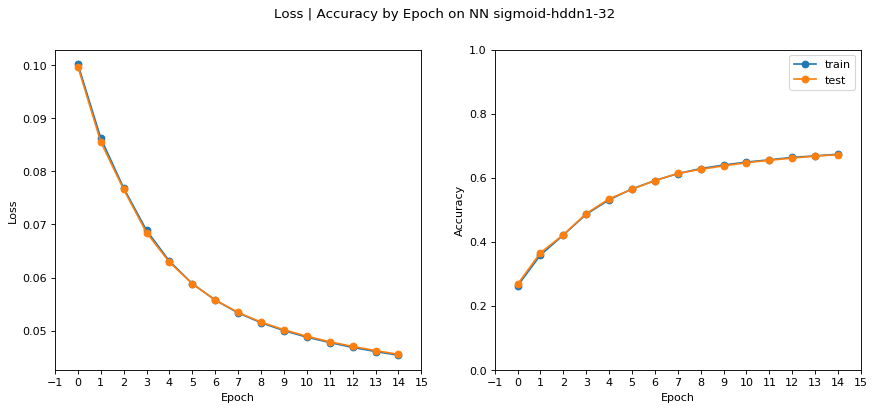

In [9]:
plot_loss_acc_by_epoch(*model_sigmoid_hddn1_32_loss_acc,
                       title=PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT % "sigmoid-hddn1-32")

# Question 1 Part 2
Change the size of your hidden layer to 16 neurons and re-run the training.

## Answer to Question Part 2

We basically reuse the above code to train the neural network and visualize the loss and accuracy changes

In [10]:
model_sigmoid_hddn1_16 = OneLayerModel(784, 16, 10)

learning_rate = 0.72

model_sigmoid_hddn1_16_loss_acc = train_network(model_sigmoid_hddn1_16,
                                                training_dataset,
                                                one_layer_train_step,
                                                lossfunc=mseloss,
                                                accfunc=prob_accuracy,
                                                num_epochs=num_epochs,
                                                batch_size=batch_size,
                                                learning_rate=learning_rate)

Test loss: 0.090198
Test accuracy: 0.262900


Test loss: 0.077172
Test accuracy: 0.395400


Test loss: 0.070018
Test accuracy: 0.465700


Test loss: 0.064668
Test accuracy: 0.510900


Test loss: 0.059918
Test accuracy: 0.548300


Test loss: 0.055572
Test accuracy: 0.586700


Test loss: 0.052155
Test accuracy: 0.617800


Test loss: 0.049430
Test accuracy: 0.641500


Test loss: 0.047221
Test accuracy: 0.663200


Test loss: 0.045391
Test accuracy: 0.677200


Test loss: 0.043845
Test accuracy: 0.688600


Test loss: 0.042457
Test accuracy: 0.699000


Test loss: 0.041296
Test accuracy: 0.706800


Test loss: 0.040246
Test accuracy: 0.713200


Test loss: 0.039291
Test accuracy: 0.719200



### Visualize loss and accuracy

Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)

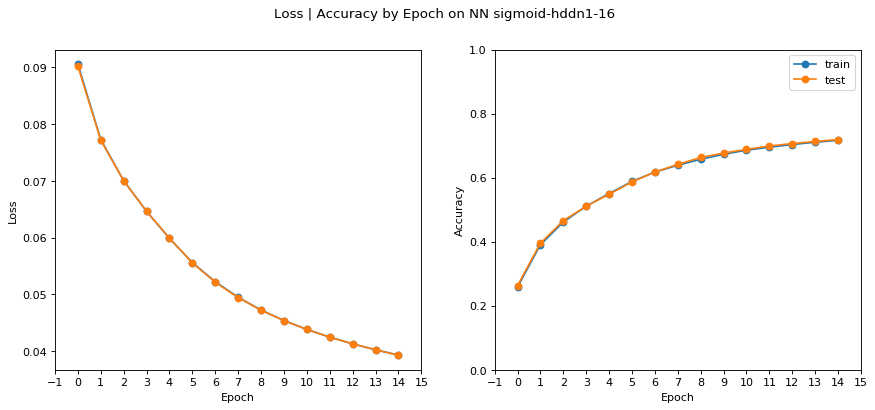

In [11]:
plot_loss_acc_by_epoch(*model_sigmoid_hddn1_16_loss_acc,
                       title=PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT % "sigmoid-hddn1-16")

# Question 1 Part 3
Change your network architecture to have two hidden layers each of size 16 and re-run the training

## Answer to Question 1 Part 3

### Model Definition

We define the following two layer model to answer the question.

In [0]:
class TwoLayerModel(object):
    def __init__(self, num_inputs, num_hidden, num_output):
        # Input to hidden 1
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden[0]),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden[0]),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='W1'))

        # Hidden 1 to hidden 2
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_hidden[1]),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden[0], num_hidden[1]),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='W2'))

        # Hidden 2 to output
        self.b3 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='b3'))
        self.W3 = tf.Variable(tf.random.normal(
            (num_hidden[1], num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='W3'))

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        a1 = tf.sigmoid(
            tf.linalg.matmul(x, self.W1) + self.b1
        )
        a2 = tf.sigmoid(
            tf.linalg.matmul(a1, self.W2) + self.b2
        )
        a3 = tf.nn.softmax(
            tf.linalg.matmul(a2, self.W3) + self.b3
        )

        return a3

### Helper Functions

Since the model definition has changed, we need to update the training step for back propagation.

In [0]:
def two_layer_train_step(model, inputs, outputs, loss, learning_rate):
    '''
    One step / batch of training

    Updates the value based on the inputs and perform back propagation
    '''
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs), outputs)
        dW1, dW2, dW3, db1, db2, db3 = t.gradient(
            current_loss, [model.W1, model.W2, model.W3, model.b1, model.b2, model.b3])

    model.W1.assign_sub(learning_rate * dW1)
    model.W2.assign_sub(learning_rate * dW2)
    model.W3.assign_sub(learning_rate * dW3)
    
    model.b1.assign_sub(learning_rate * db1)
    model.b2.assign_sub(learning_rate * db2)
    model.b3.assign_sub(learning_rate * db3)

### Training

In [14]:
model_sigmoid_hddn1_16_hddn2_16 = TwoLayerModel(784, [16, 16], 10)

model_sigmoid_hddn1_16_hddn2_16_loss_acc = train_network(model_sigmoid_hddn1_16_hddn2_16,
                                                         training_dataset,
                                                         two_layer_train_step,
                                                         lossfunc=mseloss,
                                                         accfunc=prob_accuracy,
                                                         num_epochs=num_epochs,
                                                         batch_size=batch_size,
                                                         learning_rate=learning_rate)

Test loss: 0.085372
Test accuracy: 0.287700


Test loss: 0.074778
Test accuracy: 0.383400


Test loss: 0.065472
Test accuracy: 0.495200


Test loss: 0.058062
Test accuracy: 0.562800


Test loss: 0.051977
Test accuracy: 0.619300


Test loss: 0.047171
Test accuracy: 0.664100


Test loss: 0.043271
Test accuracy: 0.698300


Test loss: 0.040206
Test accuracy: 0.722900


Test loss: 0.037689
Test accuracy: 0.740900


Test loss: 0.035556
Test accuracy: 0.754500


Test loss: 0.033797
Test accuracy: 0.766100


Test loss: 0.032164
Test accuracy: 0.778400


Test loss: 0.030824
Test accuracy: 0.787600


Test loss: 0.029627
Test accuracy: 0.798000


Test loss: 0.028584
Test accuracy: 0.806900



### Visualize loss and accuracy
Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)

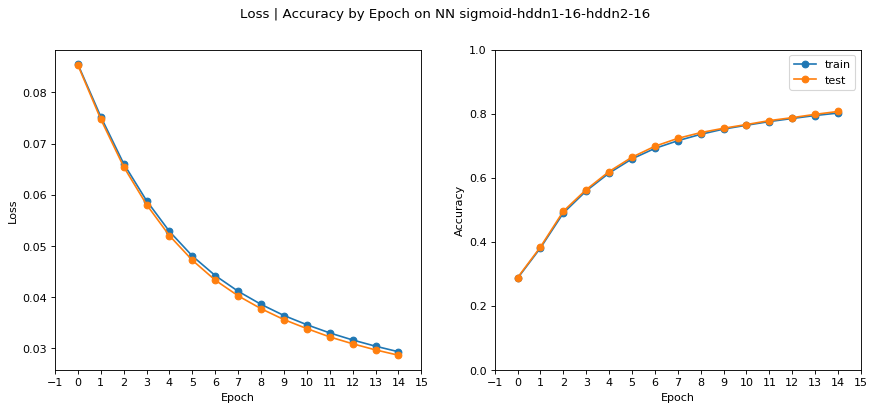

In [15]:
plot_loss_acc_by_epoch(*model_sigmoid_hddn1_16_hddn2_16_loss_acc,
                       title=PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT % "sigmoid-hddn1-16-hddn2-16")

# Question 1 Part 4
Change the activation functions in the hidden layer to ReLU and re-run the training

## Answer to Question 1 Part 4

### Model Definition

Here we modify the one layer model to meet the requirement.

In [0]:
class OneLayerReLUModel(object):
    def __init__(self, num_inputs, num_hidden, num_output):
        self.b1 = tf.Variable(tf.random.normal(
            (1, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='b1'))
        self.W1 = tf.Variable(tf.random.normal(
            (num_inputs, num_hidden),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='W1'))
        self.b2 = tf.Variable(tf.random.normal(
            (1, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='b2'))
        self.W2 = tf.Variable(tf.random.normal(
            (num_hidden, num_output),
            mean=0.0,
            stddev=1.0,
            dtype=tf.dtypes.float32,
            seed=None,
            name='W2'))

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        a1 = tf.nn.relu(
            tf.linalg.matmul(x, self.W1) + self.b1
        )
        a2 = tf.nn.softmax(
            tf.linalg.matmul(a1, self.W2) + self.b2
        )
        return a2

In [17]:
model_relu_hddn1_32 = OneLayerReLUModel(784, 32, 10)

model_relu_hddn1_32_loss_acc = train_network(model_relu_hddn1_32,
                                             training_dataset,
                                             one_layer_train_step,
                                             lossfunc=mseloss,
                                             accfunc=prob_accuracy,
                                             num_epochs=num_epochs,
                                             batch_size=batch_size,
                                             learning_rate=learning_rate)

Test loss: 0.128973
Test accuracy: 0.334200


Test loss: 0.117440
Test accuracy: 0.395400


Test loss: 0.102651
Test accuracy: 0.466400


Test loss: 0.089466
Test accuracy: 0.534500


Test loss: 0.082911
Test accuracy: 0.567700


Test loss: 0.079839
Test accuracy: 0.583100


Test loss: 0.077263
Test accuracy: 0.596500


Test loss: 0.075633
Test accuracy: 0.600800


Test loss: 0.074662
Test accuracy: 0.604500


Test loss: 0.073494
Test accuracy: 0.609600


Test loss: 0.072693
Test accuracy: 0.612700


Test loss: 0.072031
Test accuracy: 0.612600


Test loss: 0.071226
Test accuracy: 0.614500


Test loss: 0.069931
Test accuracy: 0.614400


Test loss: 0.067840
Test accuracy: 0.617500



Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


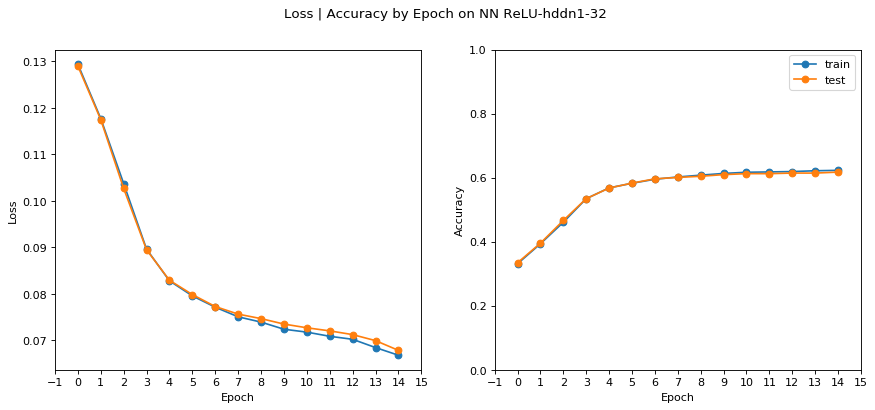

In [18]:
plot_loss_acc_by_epoch(*model_relu_hddn1_32_loss_acc,
                       title=PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT % "ReLU-hddn1-32")

# Question 1 part 5
Describe how changing the size of the hidden layer and the number of hidden layers impacted the predictions of the network.

## Answer to Question 1 Part 5

In previous parts, we used a single-layer neural network that has a hidden layer of size 32 as the baseline. We tested based on the three configuration, 1) varying the number of neurons in the hidden layer from 32 to 16, 2) varying the number of hidden layers from 1 to 2, and 3) varying the activation function from sigmoid to ReLU. In this part, we would like to discuss the implication on how configurations on the hidden layer changes the fitting results. The below graph collects the performance plot for all 4 models printed above.

In [0]:
__data = {
    "hddn1-32" : model_sigmoid_hddn1_32_loss_acc, 
    "hddn1_16" : model_sigmoid_hddn1_16_loss_acc, 
    "hddn1_16_hddn2_16" : model_sigmoid_hddn1_16_hddn2_16_loss_acc, 
    "relu_hddn1_32" : model_relu_hddn1_32_loss_acc
}

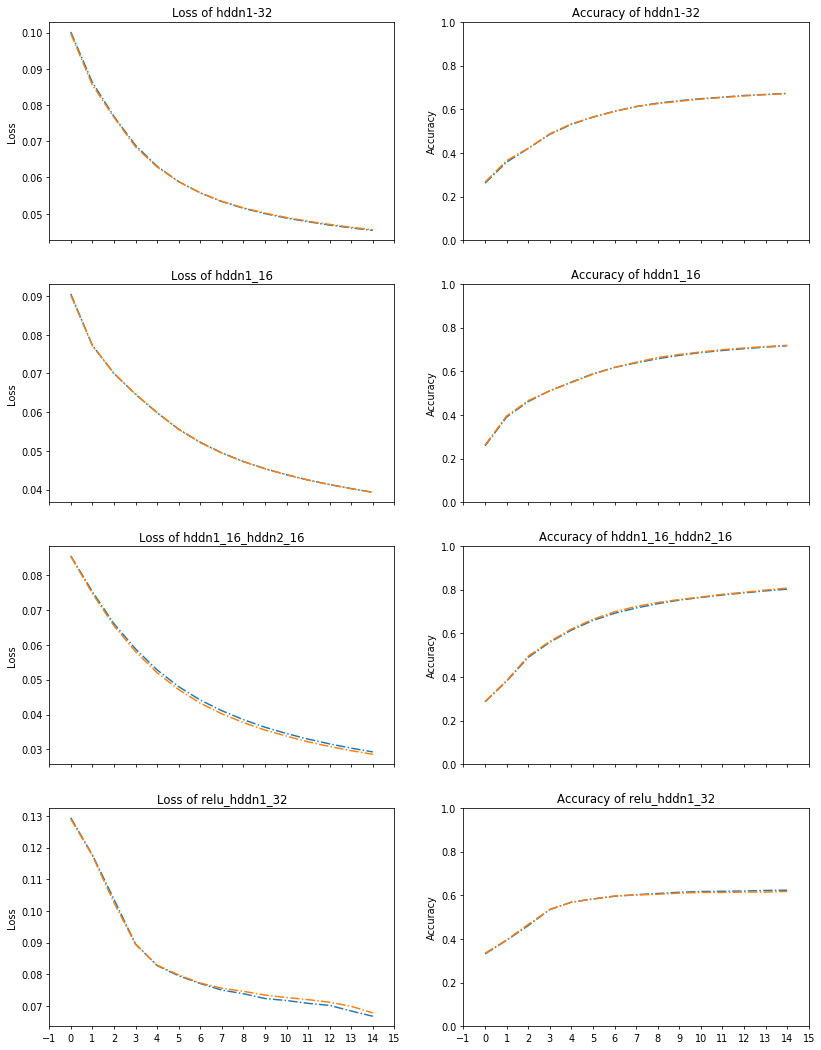

In [20]:
fig, axs = plt.subplots(4, 2, sharex=True, dpi=70, figsize=[14,19])


for idx, ((lossax, accax), (__name, (__trloss, __tracc, __tstloss, __tstacc))) in enumerate(zip(axs, __data.items())):
    lossax.set_ylabel("Loss")
    lossax.set_xlim([-1, len(__trloss)])
    lossax.set_xticks(range(-1, len(__trloss) + 1))
    lossax.set_title("Loss of %s" % __name)
    lossax.plot(__trloss, "-.")
    lossax.plot(__tstloss, "-.")
    
    accax.set_ylabel("Accuracy")
    accax.set_ylim([0, 1])
    accax.set_title("Accuracy of %s" % __name)
    __train_line, *_ = accax.plot(__tracc, "-.")
    __test_line, *_  = accax.plot(__tstacc, "-.")

We discuss the three variations accordingly.

1. Change the size of hidden layer (One hidden layer with 32 neuron `hddn1_32` vs. One hidden layer with 16 neuron `hddn1_16`)

    There is no obvious changes between in comparison. Both reached the same level of performance.
    
2. Change the number of hidden layer (One hidden layer with 32 neuron `hddn1_32` vs. One hidden layer with 16 neuron `hddn1_16_hddn2_16`)
    
    There is no obvious changes between in comparison. Both reached the same level of performance.
    
3. Change the type of neuron in the hidden layer (One hidden layer with 32 neuron `hddn1_32` vs. One hidden layer with 32 neuron using ReLU `relu_hddn1_32`)

    ReLU converges pretty fast. But both reach the same level of performance.
    
In field of machine learning, the general rule of thumb is that as the network gets wider and deeper, the representability of the network is greatly increased. The choice of neurons also has an effect, mostly on the training processes. Here in our case, the MNIST is quite a simple problem in classification. This might be the main reason why there is not much of difference when we vary the size of the network. 

    
    

# Question 2 Part 1

Re-use the network built above but modify the update step to the following.

\begin{align}
V_t = \beta V_{t-1} + (1-\beta)g_t \\
W_{t+1} = W_t - \alpha V_t
\end{align}

where $V_t$ is the update vector for step $t$. Use $\beta=0.1$.

In [0]:
class MomentumSGDTrainStepper:
    
    def __init__(self, β=0.1):
        self.β = β
        self.is_first_step = True
        self.LW1 = None
        self.LW2 = None
        self.Lb1 = None
        self.Lb2 = None
        
    def __call__(self, model, inputs, outputs, loss, learning_rate):
        # Compute gradient
        with tf.GradientTape() as t:
            current_loss = loss(model(inputs), outputs)
            dW1, dW2, db1, db2 = t.gradient(
                current_loss, [model.W1, model.W2, model.b1, model.b2])

        dW1 = (1 - self.β) * dW1
        dW2 = (1 - self.β) * dW2
        db1 = (1 - self.β) * db1
        db2 = (1 - self.β) * db2
        # Compute momentum
        if not self.is_first_step:
            dW1 += self.β * self.LW1
            dW2 += self.β * self.LW2
            db1 += self.β * self.Lb1
            db2 += self.β * self.Lb2
        
        self.LW1 = dW1
        self.LW2 = dW2
        self.Lb1 = db1
        self.Lb2 = db2
        self.is_first_step = False
            
        model.W1.assign_sub(learning_rate * dW1)
        model.W2.assign_sub(learning_rate * dW2)
        model.b1.assign_sub(learning_rate * db1)
        model.b2.assign_sub(learning_rate * db2)

In [22]:
model_sigmoid_hddn1_32_momemtum_p1 = OneLayerModel(784, 32, 10)

learning_rate = 0.72
num_epochs = 15
batch_size = 64

momemtum_train_step_p1 = MomentumSGDTrainStepper(β=0.1)

model_sigmoid_hddn1_32_momemtum_p1_loss_acc = train_network(model_sigmoid_hddn1_32_momemtum_p1,
                                                            training_dataset,
                                                            momemtum_train_step_p1,
                                                            lossfunc=mseloss,
                                                            accfunc=prob_accuracy,
                                                            num_epochs=num_epochs,
                                                            batch_size=batch_size,
                                                            learning_rate=learning_rate)

Test loss: 0.083554
Test accuracy: 0.341800


Test loss: 0.065362
Test accuracy: 0.503000


Test loss: 0.055791
Test accuracy: 0.587700


Test loss: 0.050558
Test accuracy: 0.629600


Test loss: 0.047045
Test accuracy: 0.658800


Test loss: 0.044303
Test accuracy: 0.680800


Test loss: 0.042209
Test accuracy: 0.698400


Test loss: 0.040469
Test accuracy: 0.711800


Test loss: 0.039016
Test accuracy: 0.723400


Test loss: 0.037819
Test accuracy: 0.733500


Test loss: 0.036780
Test accuracy: 0.741900


Test loss: 0.035868
Test accuracy: 0.748200


Test loss: 0.034916
Test accuracy: 0.753600


Test loss: 0.031505
Test accuracy: 0.778400


Test loss: 0.025865
Test accuracy: 0.825300



Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


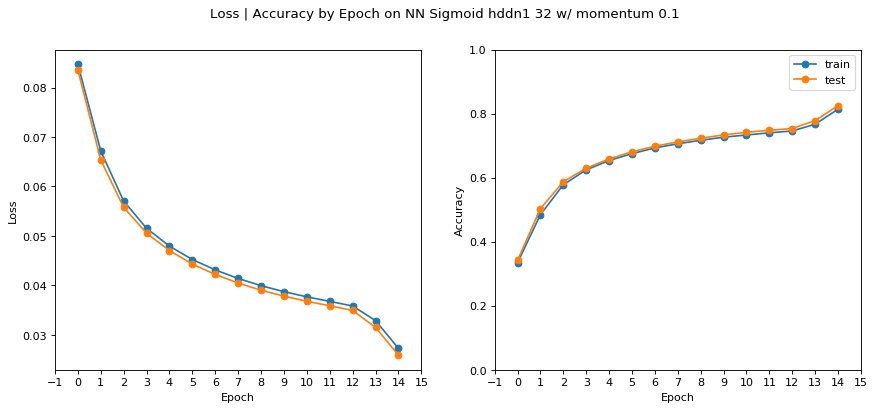

In [23]:
plot_loss_acc_by_epoch(*model_sigmoid_hddn1_32_momemtum_p1_loss_acc,
                       title=PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT % "Sigmoid hddn1 32 w/ momentum 0.1")

## Question 2 part 2
Re-run the training with $\beta=0.9$

In [24]:
model_sigmoid_hddn1_32_momemtum_p2 = OneLayerModel(784, 32, 10)

momemtum_train_step_p2 = MomentumSGDTrainStepper(β=0.9)

model_sigmoid_hddn1_32_momemtum_p2_loss_acc = train_network(model_sigmoid_hddn1_32_momemtum_p2,
                                                            training_dataset,
                                                            momemtum_train_step_p2,
                                                            lossfunc=mseloss,
                                                            accfunc=prob_accuracy,
                                                            num_epochs=num_epochs,
                                                            batch_size=batch_size,
                                                            learning_rate=learning_rate)

Test loss: 0.108185
Test accuracy: 0.183900


Test loss: 0.081517
Test accuracy: 0.372200


Test loss: 0.060989
Test accuracy: 0.550000


Test loss: 0.051037
Test accuracy: 0.627200


Test loss: 0.045755
Test accuracy: 0.671500


Test loss: 0.042102
Test accuracy: 0.697700


Test loss: 0.038715
Test accuracy: 0.724400


Test loss: 0.035079
Test accuracy: 0.754200


Test loss: 0.032128
Test accuracy: 0.777700


Test loss: 0.029930
Test accuracy: 0.794400


Test loss: 0.028279
Test accuracy: 0.806600


Test loss: 0.026880
Test accuracy: 0.816700


Test loss: 0.025742
Test accuracy: 0.826700


Test loss: 0.024790
Test accuracy: 0.833500


Test loss: 0.023943
Test accuracy: 0.839700



Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


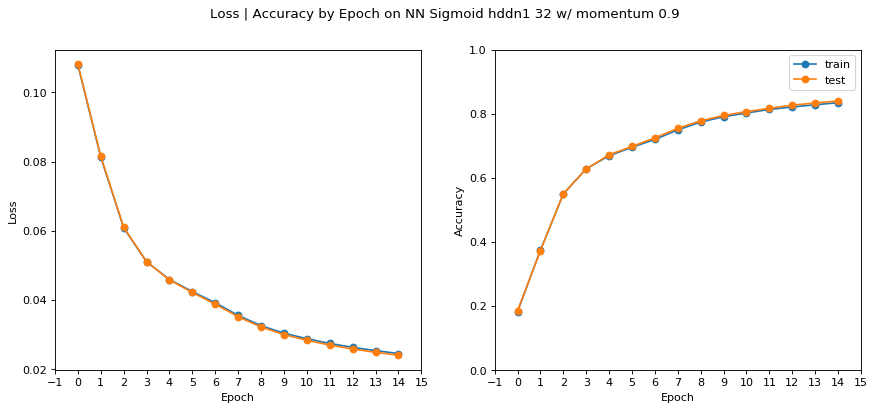

In [25]:
plot_loss_acc_by_epoch(*model_sigmoid_hddn1_32_momemtum_p2_loss_acc,
                       title=PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT % "Sigmoid hddn1 32 w/ momentum 0.9")

## Question 2 Part 3
Describe the differences in training results comparing the different values of $\beta$.

### Answer to Question 2 Part 3

For this specific optimization function, it updates the parameters using the weighted sum of previous update value and current gradient. As the value of $\beta$ increases, the previous update value has a larger influences on current update value. 

## Question 2 Part 4
Re-use the network above, but implement the [AdaDelta](http://ruder.io/optimizing-gradient-descent/index.html#adadelta) learning algorithm. You can assume an initial value of $RMS[\nabla \theta]_{t-1} = 1.0$

In [0]:
class AdaDeltaTrainStepper:
    
    def __init__(self, ρ, ϵ = 1e-6):
        self.ρ = ρ
        self.ϵ = ϵ
        # gradient accumulation
        self.EgW1sq = 0
        self.EgW2sq = 0
        self.Egb1sq = 0
        self.Egb2sq = 0
        # update accumulation
        self.EdW1sq = 0
        self.EdW2sq = 0
        self.Edb1sq = 0
        self.Edb2sq = 0

    def __call__(self, model, inputs, outputs, loss, learning_rate):
        # Compute gradient
        with tf.GradientTape() as t:
            current_loss = loss(model(inputs), outputs)
            dW1, dW2, db1, db2 = t.gradient(
                current_loss, [model.W1, model.W2, model.b1, model.b2])
        
        # Accumulate gradient
        self.EgW1sq = self.ρ * self.EgW1sq + (1 - self.ρ) * dW1**2
        self.EgW2sq = self.ρ * self.EgW2sq + (1 - self.ρ) * dW2**2
        self.Egb1sq = self.ρ * self.Egb1sq + (1 - self.ρ) * db1**2
        self.Egb2sq = self.ρ * self.Egb2sq + (1 - self.ρ) * db2**2
        
        # Compute update
        dW1 = - tf.sqrt(self.EdW1sq + self.ϵ) / \
                tf.sqrt(self.EgW1sq + self.ϵ) * dW1
        dW2 = - tf.sqrt(self.EdW2sq + self.ϵ) / \
                tf.sqrt(self.EgW2sq + self.ϵ) * dW2
        db1 = - tf.sqrt(self.Edb1sq + self.ϵ) / \
                tf.sqrt(self.Egb1sq + self.ϵ) * db1
        db2 = - tf.sqrt(self.Edb2sq + self.ϵ) / \
                tf.sqrt(self.Egb2sq + self.ϵ) * db2
        
        # Accumulate update
        self.EdW1sq = self.ρ * self.EdW1sq + (1 - self.ρ) * dW1**2
        self.EdW2sq = self.ρ * self.EdW2sq + (1 - self.ρ) * dW2**2
        self.Edb1sq = self.ρ * self.Edb1sq + (1 - self.ρ) * db1**2
        self.Edb2sq = self.ρ * self.Edb2sq + (1 - self.ρ) * db2**2
        
        # Apply update
        model.W1.assign_add(dW1)
        model.W2.assign_add(dW2)
        model.b1.assign_add(db1)
        model.b2.assign_add(db2)

In [27]:
model_sigmoid_hddn1_32_adadelta = OneLayerModel(784, 32, 10)

adadelta_train_step = AdaDeltaTrainStepper(0.95)

model_sigmoid_hddn1_32_adadelta_loss_acc = train_network(model_sigmoid_hddn1_32_adadelta,
                                                            training_dataset,
                                                            adadelta_train_step,
                                                            lossfunc=mseloss,
                                                            accfunc=prob_accuracy,
                                                            num_epochs=num_epochs,
                                                            batch_size=batch_size,
                                                            learning_rate=learning_rate)

Test loss: 0.082920
Test accuracy: 0.380300


Test loss: 0.063712
Test accuracy: 0.536600


Test loss: 0.054696
Test accuracy: 0.614500


Test loss: 0.050925
Test accuracy: 0.641900


Test loss: 0.048591
Test accuracy: 0.659500


Test loss: 0.046956
Test accuracy: 0.671000


Test loss: 0.045691
Test accuracy: 0.679400


Test loss: 0.044585
Test accuracy: 0.688900


Test loss: 0.043730
Test accuracy: 0.694100


Test loss: 0.042929
Test accuracy: 0.699500


Test loss: 0.042078
Test accuracy: 0.702500


Test loss: 0.038484
Test accuracy: 0.729500


Test loss: 0.034748
Test accuracy: 0.761800


Test loss: 0.032904
Test accuracy: 0.775300


Test loss: 0.031771
Test accuracy: 0.784400



Plot the training and testing loss and the training and testing accuracy by epoch using [matplotlib](https://chrisalbon.com/deep_learning/keras/visualize_loss_history/)


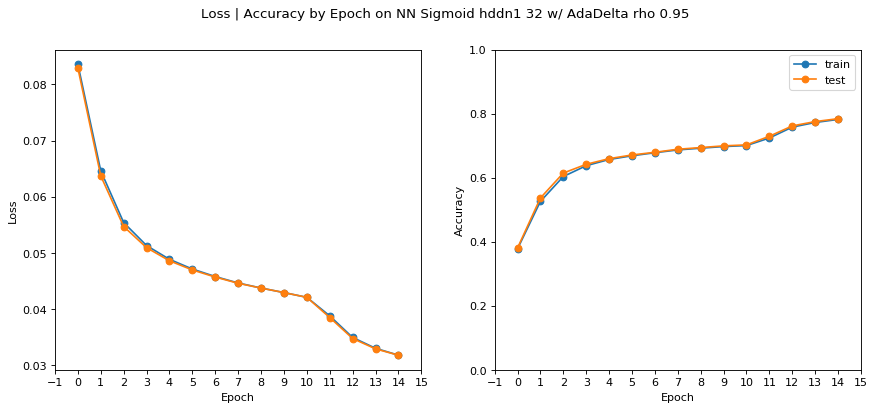

In [28]:
plot_loss_acc_by_epoch(*model_sigmoid_hddn1_32_adadelta_loss_acc,
                       title=PLOT_LOSS_ACC_BY_EPOCH_TITLE_FORMAT % "Sigmoid hddn1 32 w/ AdaDelta rho 0.95")